### 1. Imports and Setup
We start by importing the necessary libraries. This includes `torch` for the deep learning framework, `cv2` and `PIL` for image processing, and standard libraries for file handling and math. We also set up the environment to display plots inline.

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
import cv2

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import subprocess
import os
from PIL import Image
import time
from tqdm import tqdm

from IPython import display
display.clear_output()


### 2. Intersection Over Union (IoU)
This function calculates the **Intersection Over Union (IoU)** between predicted bounding boxes and ground truth boxes. IoU is a fundamental metric in object detection used to measure the overlap between two boxes. It is used later in both the loss function and Non-Max Suppression.

In [4]:

def IOU(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """
    if box_format == "midpoint" :
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners" :
        box1_x1, box1_y1 = boxes_preds[..., 0:1], boxes_preds[..., 1:2]
        box1_x2, box1_y2 = boxes_preds[..., 2:3], boxes_preds[..., 3:4]
        box2_x1, box2_y1 = boxes_labels[..., 0:1], boxes_labels[..., 1:2]
        box2_x2, box2_y2 = boxes_labels[..., 2:3], boxes_labels[..., 3:4]

    x1, y1 = torch.max(box1_x1, box2_x1), torch.max(box1_y1, box2_y1)
    x2, y2 = torch.min(box1_x2, box2_x2), torch.min(box1_y2, box2_y2)

    inter = (x2-x1).clamp(0) * (y2-y1).clamp(0)
    box1_area = abs( (box1_x2 - box1_x1) * (box1_y2 - box1_y1) )
    box2_area = abs( (box2_x2 - box2_x1) * (box2_y2 - box2_y1) )
    uni = box1_area + box2_area - inter

    return inter / (uni + 1e-6)

### 3. Non-Max Suppression (NMS) and Mean Average Precision (mAP)
Here we implement two critical evaluation components:
* **`NMS` (Non-Max Suppression):** cleans up the output by removing multiple overlapping bounding boxes for the same object, keeping only the one with the highest confidence.
* **`MAP` (Mean Average Precision):** is the standard performance metric for object detection. It calculates the average precision for each class and then averages them across all classes.

In [ ]:

def NMS(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or IOU(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def MAP(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """
    
    avg_precisions = []
    epsilon = 1e-6 # used for numerical stability
    for c in range(num_classes):
        detections, ground_truths = [], []
        for detection in pred_boxes:
            if detection[1] == c: detections.append(detection)
        for true_box in true_boxes :
            if true_box[1] == c: ground_truths.append(true_box)
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key,val in amount_bboxes.items(): amount_bboxes[key] = torch.zeros(val)
        detections.sort(key=lambda x:x[2], reverse=True)
        TP, FP, total_true_bboxes = torch.zeros(len(detections)), torch.zeros(len(detections)), len(ground_truths)
        if total_true_bboxes == 0:
            continue
        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [ bbox for bbox in ground_truths if bbox[0] == detection[0] ]
            num_gts = len(ground_truth_img)
            best_iou = 0
            for idx, gt in enumerate(ground_truth_img) :
                iou = IOU(torch.tensor(detection[3:]), torch.tensor(gt[3:]), box_format=box_format,)
                if iou > best_iou :
                    best_iou = iou
                    best_gt_idx = idx
            if best_iou > iou_threshold :
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else :
                    FP[detection_idx] = 1
            else :
                FP[detection_idx] = 1
        TP_cumsum, FP_cumsum = torch.cumsum(TP, dim=0), torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions, recalls = torch.cat((torch.tensor([1]), precisions)), torch.cat((torch.tensor([0]), recalls))
        avg_precisions.append(torch.trapz(precisions, recalls))

    return sum(avg_precisions) / (len(avg_precisions) + epsilon)


### 4. Plotting Utility
A simple helper function to visualize a standard image tensor with its corresponding bounding boxes using Matplotlib patches.

In [5]:

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width, box[3] * height,
            linewidth=1, edgecolor="r", facecolor="none",
        )
        ax.add_patch(rect)
    plt.show()

### 5. Convert Grid Coordinates to Image Coordinates
The YOLO model outputs coordinates relative to specific grid cells. This function converts those "cell-relative" predictions into "image-relative" coordinates, which are necessary for plotting and final evaluation.

In [ ]:

def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

### 6. Data Processing and Checkpoint Utilities
* **`cellboxes_to_boxes`**: Converts the raw model output (batch of grids) into a list of bounding boxes.
* **`makeCSVfile`**: Scans the dataset directories to create a generic dataframe for loading.
* **`save_checkpoint` / `load_checkpoint`**: Utilities to save and load model weights during training.

In [ ]:

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def makeCSVfile(dataset_location, folder):
    images = subprocess.check_output("ls "+ dataset_location + folder + '/images', shell=True, text=True).split('\n')[:-1]
    labels = subprocess.check_output("ls "+ dataset_location + folder + '/labels', shell=True, text=True).split('\n')[:-1]
    return pd.DataFrame(data = {'image': images, 'text':labels})

def save_checkpoint(state, filename="my_checkpoint.pth.tar", exit_training=False):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    if exit_training : exit()

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    

### 7. Get Bounding Boxes Loop
This function iterates through a dataloader to generate predictions. It applies NMS to the raw predictions and returns clean lists of predicted vs. true bounding boxes, which are required to calculate mAP.

In [20]:

def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = NMS(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

### 8. YOLOv1 Architecture Configuration
This list defines the YOLOv1 architecture layout.
* **Tuples**: `(kernel_size, num_filters, stride, padding)`
* **"M"**: MaxPool layer
* **Lists**: Define repeating blocks of convolutional layers.

In [9]:


architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


### 9. YOLOv1 Model Implementation
Here we define the model structure:
* **`CNNBlock`**: A standard block containing a Convolutional layer, BatchNorm, and LeakyReLU.
* **`Yolov1`**: The main class that parses the `architecture_config` to build the Darknet feature extractor and appends the fully connected layers for the final detection head.

In [10]:

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels) # not present in the original YOLO model
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super().__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x): return self.fcs(torch.flatten(self.darknet(x), start_dim=1))

    def _create_conv_layers(self, architecture):
        in_channels = self.in_channels
        layers = []
        for x in architecture:
            if type(x)==tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]
            elif type(x)==str:
                layers += [ nn.MaxPool2d(kernel_size=2, stride=2) ]
            elif type(x)==list:
                conv1, conv2, num_repeats = x[0], x[1], x[2]
                for i in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S,496), #4096 in YOLO paper
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S*S*(B*5+C))
        )

### 10. YOLO Loss Function
This class implements the custom loss function described in the YOLO paper, which is a weighted sum of four components:
1.  **Box Coordinates Loss**: Penalizes errors in bounding box position and size.
2.  **Object Loss**: Penalizes confidence errors when an object is present.
3.  **No-Object Loss**: Penalizes confidence errors for background cells (weighted lower).
4.  **Class Loss**: Penalizes classification errors.

In [ ]:

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S, self.B, self.C = S, B, C
        self.lambda_coord, self.lambda_noobj = 5, .5

    def forward(self, predictions, target ):
        predictions = predictions.reshape(-1, self.S, self.S, self.B*5+self.C)
        ious = torch.cat(
            (IOU(predictions[...,21:25], target[...,21:25]).unsqueeze(0),
            IOU(predictions[...,26:30], target[...,21:25]).unsqueeze(0))
        )
        _, bestbox = torch.max(ious, dim=0)
        exists_box = target[...,20:21]

        box_predictions =  exists_box * ( (1-bestbox)*predictions[...,21:25] + bestbox*predictions[...,26:30] )
        box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
        box_targets = exists_box * target[...,21:25] #!!!
        box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2)
        )
        object_loss = self.mse(
            torch.flatten(exists_box * ( (1-bestbox)*predictions[...,20:21] + bestbox*predictions[...,25:26] )),
            torch.flatten(exists_box)
        )
        no_object_loss=self.mse(
            torch.flatten((1-exists_box) * predictions[...,20:21], end_dim=-2),
            torch.flatten((1-exists_box) * target[...,20:21], end_dim=-2)
        ) + self.mse(
            torch.flatten((1-exists_box) * predictions[...,25:26], end_dim=-2),
            torch.flatten((1-exists_box) * target[...,20:21], end_dim=-2)
        )
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[...,:20], end_dim=-2),
            torch.flatten(exists_box * target[...,:20], end_dim=-2)
        )
        loss = (self.lambda_coord*box_loss + object_loss + self.lambda_noobj*no_object_loss + class_loss)
        return loss



### 11. Pascal VOC Dataset
A custom PyTorch Dataset class that:
1.  Loads images and their corresponding label files.
2.  Applies transformations.
3.  Encodes the labels into the specific $S \times S \times (B \times 5 + C)$ tensor format required by the YOLO loss function.

In [ ]:



class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, label_dir, img_dir, S=7, B=2, C=20, transform=None):
        self.annotations = csv_file
        self.label_dir, self.img_dir = label_dir, img_dir
        self.transform = transform
        self.S, self.B, self.C = S, B, C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])

        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Warning: Could not load image at {img_path}")
            image = Image.new('RGB', (448, 448))
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

        boxes = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for label in f.readlines():
                    parts = label.strip().split()
                    if len(parts) == 5:
                        class_label, x, y, width, height = [
                            float(x) if float(x) != int(float(x)) else int(x) 
                            for x in parts
                        ]
                        boxes.append([class_label, x, y, width, height])
        
        if self.transform:
            boxes_tensor = torch.tensor(boxes) if boxes else torch.zeros((0, 5))
            image, boxes = self.transform(image, boxes_tensor)

        label_matrix = torch.zeros(self.S, self.S, self.B * 5 + self.C)
        
        if isinstance(boxes, torch.Tensor):
            boxes = boxes.tolist()

        for box in boxes:
            class_label, x, y, width, height = box
            
            # Identify the cell (i, j)
            i, j = int(y * self.S), int(x * self.S)
            
            # Safety check: ensure i and j are within grid bounds (0-6)
            if i >= self.S or j >= self.S:
                continue

            x_cell, y_cell = x * self.S - j, y * self.S - i
            w_cell, h_cell = width * self.S, height * self.S

            # If no object already in this cell, assign it
            # Index 20 is the confidence score for the first bounding box
            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1
                label_matrix[i, j, int(class_label)] = 1
                label_matrix[i, j, 21:25] = torch.tensor([x_cell, y_cell, w_cell, h_cell])

        return image, label_matrix


### 12. Hyperparameters and Constants
We define the global training parameters (learning rate, batch size, epochs), setup the device (CPU/GPU), and define the file paths for the train/test datasets.

In [ ]:

"""
Main file for training Yolo model on Pascal VOC dataset
"""
seed = 123
torch.manual_seed(seed)
# print("dataset location:", dataset.location)

dataset_location = '/home/rocinate/ADLR_niwesh/final_sapien/Q1/VOC-2012-1'

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
BATCH_SIZE = 16 # 64 in original
WEIGHT_DECAY = 0
EPOCHS = 9
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "./last_yolo_model.pth.tar"
IMG_DIR_TRAIN = f"{dataset_location}/train/images"
LABEL_DIR_TRAIN = f"{dataset_location}/train/labels"
IMG_DIR_TEST = f"{dataset_location}/test/images"
LABEL_DIR_TEST = f"{dataset_location}/test/labels"

### 13. Image Transformations
Defines the preprocessing pipeline. Crucially, this resizes all input images to **448x448**, which is the fixed input size required by the YOLOv1 fully connected layers.

In [ ]:

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


# This ensures that images are resized and converted to tensors
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


### 14. Single Epoch Training Function
This function handles the training logic for a single epoch: it performs the forward pass, calculates the loss, computes gradients (backward pass), and updates the model weights.

In [ ]:

# Training function for one epoch
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

### 15. Main Training Loop
The main driver function that:
1.  Initializes the model, optimizer, and loss.
2.  Loads previous checkpoints if enabled.
3.  Iterates through epochs, running training and validation steps.
4.  Saves the model checkpoint every epoch and saves a separate "best" model when mAP improves.

In [ ]:
# Final Training loop
def training_loop():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss()

    # 1. Initialize start_epoch to 0
    start_epoch = 0

    if LOAD_MODEL and os.path.isfile(LOAD_MODEL_FILE):
        print("=> Loading Checkpoint...")
        # 2. Capture the checkpoint object so we can read the epoch key
        checkpoint = torch.load(LOAD_MODEL_FILE, map_location=DEVICE)
        load_checkpoint(checkpoint, model, optimizer)
        
        # 3. If 'epoch' was saved, update start_epoch to resume from the next one
        if "epoch" in checkpoint:
            start_epoch = checkpoint["epoch"] + 1
            print(f"=> Resuming training from epoch {start_epoch}")
        else:
            print("=> No epoch info in checkpoint. Starting from epoch 0.")

    train_dataset = VOCDataset(makeCSVfile(dataset_location, '/train'),
                               transform=transform, img_dir=IMG_DIR_TRAIN, label_dir=LABEL_DIR_TRAIN)

    test_dataset = VOCDataset(makeCSVfile(dataset_location, '/test'),
                              transform=transform, img_dir=IMG_DIR_TEST, label_dir=LABEL_DIR_TEST)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
                             pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

    # 4. Update the loop range to start from start_epoch
    for epoch in range(start_epoch, EPOCHS):
        
        print(f"Starting Epoch {epoch}")
        
        # --- TRAINING STEP ---
        train_fn(train_loader, model, optimizer, loss_fn)

        # --- VALIDATION STEP ---
        pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE)
        mean_avg_prec = MAP(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
        print(f"Epoch: {epoch} | test mAP: {mean_avg_prec}")
        
        pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE)
        mean_avg_prec = MAP(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
        print(f"Epoch: {epoch} | train mAP: {mean_avg_prec}")

        # --- CHECKPOINTING ---
        # Create a checkpoint dictionary that includes the current epoch
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,  # Essential for resuming
        }
        
        # Save the "Latest" state every epoch (for resuming)
        save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

        # Optional: Save "Best" model separately to avoid overwriting your progress with a worse model
        if mean_avg_prec > 0.6:
            save_checkpoint(checkpoint, filename="yolov1_best.pth.tar")
            print("=> Best model saved!")

### 16. Start Training
Execute the cell below to start the training process.

In [23]:
training_loop()

=> Loading Checkpoint...
=> Loading checkpoint
=> Resuming training from epoch 96


### 17. Visualization Setup
We define the class names for the Pascal VOC dataset and generate random colors for each class to distinctively visualize bounding boxes.

In [39]:
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

COLORS = np.random.uniform(0, 255, size=(len(VOC_CLASSES), 3))


### 18. Prediction Plotting Helper
A specialized function to draw bounding boxes and class labels on an image. It handles the "denormalization" of coordinates (converting 0-1 values back to pixel values).

In [32]:


def plot_prediction(image, boxes, title="Prediction", ax=None):
    """
    Plots the image with bounding boxes.
    If ax is provided, plots on that axis, otherwise creates a new figure.
    """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    # Image is a tensor (C, H, W), convert to numpy (H, W, C)
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).to("cpu").numpy()
        
    ax.imshow(image)
    ax.set_title(title)
    ax.axis("off")

    height, width, _ = image.shape

    for box in boxes:
        # box format: [class_idx, confidence, x, y, w, h]
        class_idx = int(box[0])
        conf = box[1]
        box_vals = box[2:]
        
        # Denormalize coordinates
        x_c, y_c, w, h = box_vals
        x1 = (x_c - w/2) * width
        y1 = (y_c - h/2) * height
        rect_w = w * width
        rect_h = h * height

        # Get color for this class
        color = COLORS[class_idx] / 255.0

        # Create Rectangle patch
        rect = patches.Rectangle(
            (x1, y1), rect_w, rect_h,
            linewidth=2, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)

        # Add Label text
        label_text = f"{VOC_CLASSES[class_idx]}"
        ax.text(
            x1, y1, label_text,
            color='white', fontsize=10, backgroundcolor=color,
            verticalalignment='top', bbox={'color': color, 'pad': 0}
        )
    
    if ax is None:
        plt.show()
        
        
        

### 19. Visualization Wrapper
This function runs inference on a batch of test images and displays side-by-side comparisons of the **Ground Truth** vs. the **Model Predictions** (after NMS).

In [33]:

def visualize_results(model, loader, device, iou_threshold=0.5, threshold=0.4, num_samples=3):
    model.eval()
    
    # Get a single batch
    x, y = next(iter(loader))
    x = x.to(device)
    
    with torch.no_grad():
        predictions = model(x)

    # Convert raw cell predictions to bounding boxes
    batch_bboxes = cellboxes_to_boxes(predictions)
    true_bboxes = cellboxes_to_boxes(y)

    # Visualize first N samples
    for idx in range(min(num_samples, x.shape[0])):
        
        # 1. Process Predictions (Apply NMS)
        nms_boxes = NMS(
            batch_bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
            box_format="midpoint",
        )
        
        # 2. Process Ground Truth (Filter low confidence dummy boxes)
        gt_boxes = [box for box in true_bboxes[idx] if box[1] > threshold]

        # 3. Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # Get image from GPU to CPU
        img_tensor = x[idx].cpu()
        
        plot_prediction(img_tensor, gt_boxes, title="Ground Truth", ax=ax1)
        plot_prediction(img_tensor, nms_boxes, title=f"Model Prediction (Conf > {threshold})", ax=ax2)
        
        plt.tight_layout()
        plt.show()

    model.train() # Switch back to train mode just in case

### 20. Execute Visualization and FPS Calculation
Finally, we load the best saved model state, visualize the predictions on a few test samples, and calculate the average Frames Per Second (FPS) to measure the model's inference speed.

=> Loading yolov1_best.pth.tar for testing...

=== VISUALIZING MODEL PREDICTIONS ===


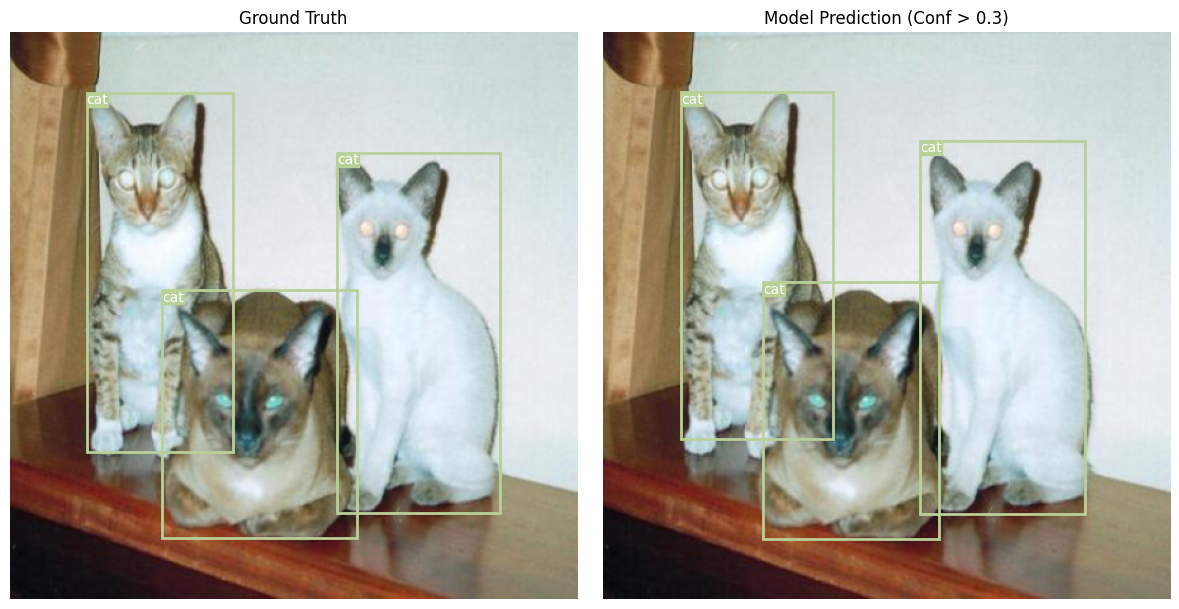

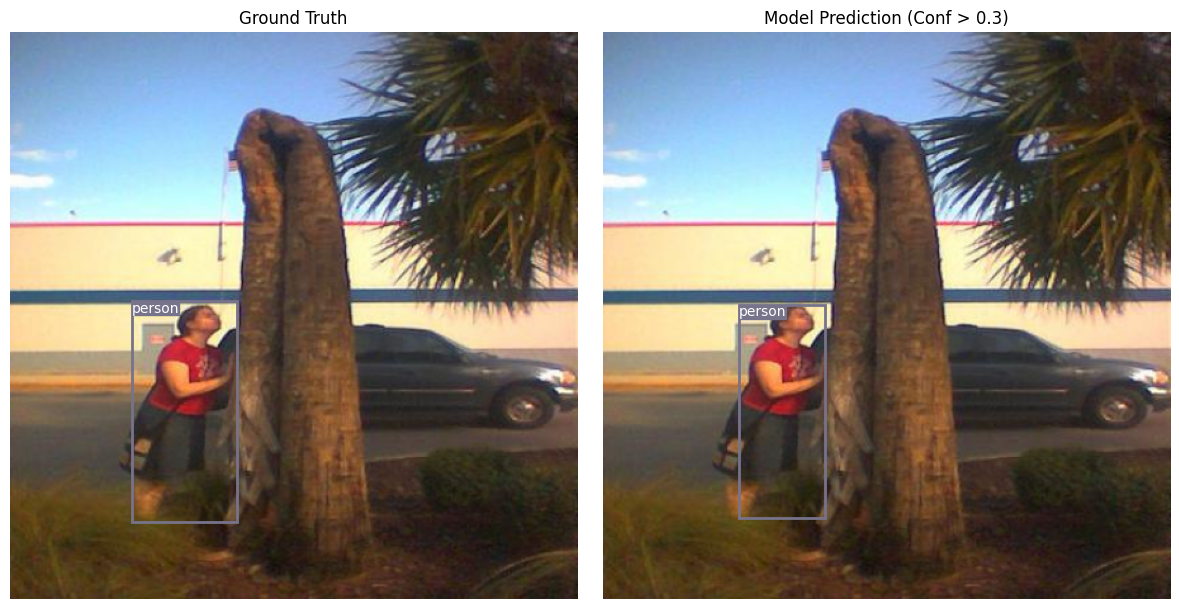

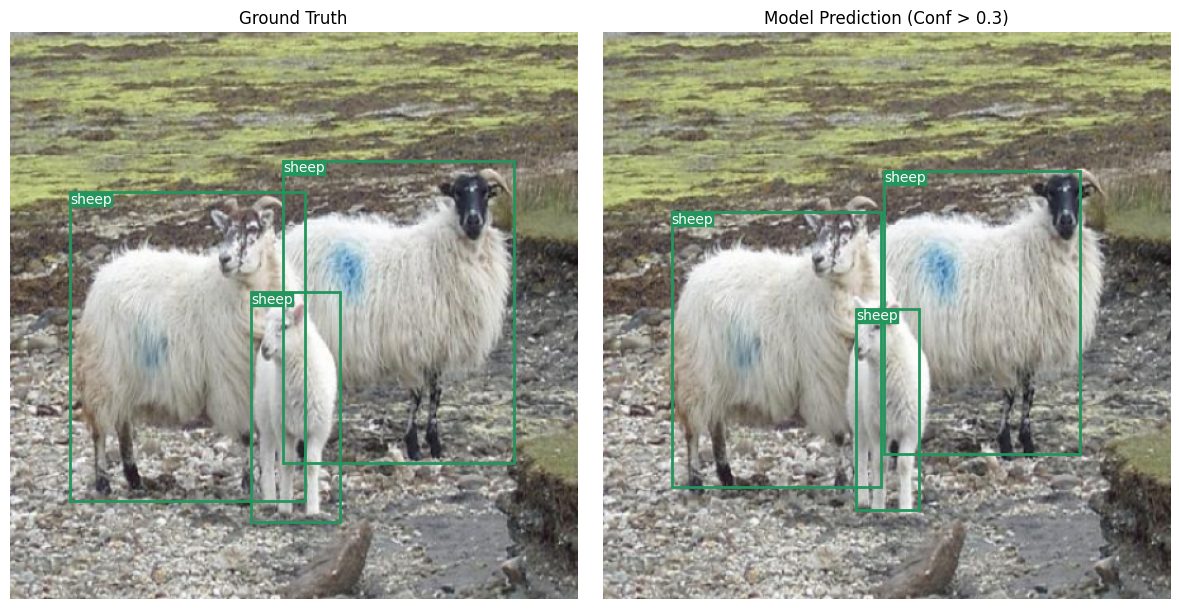

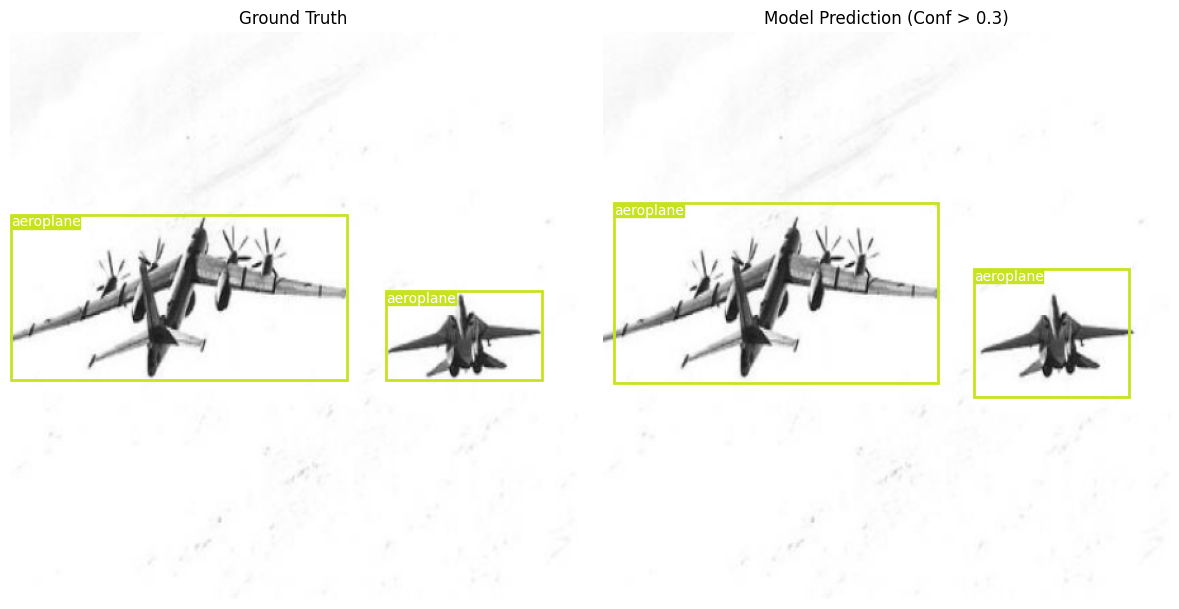

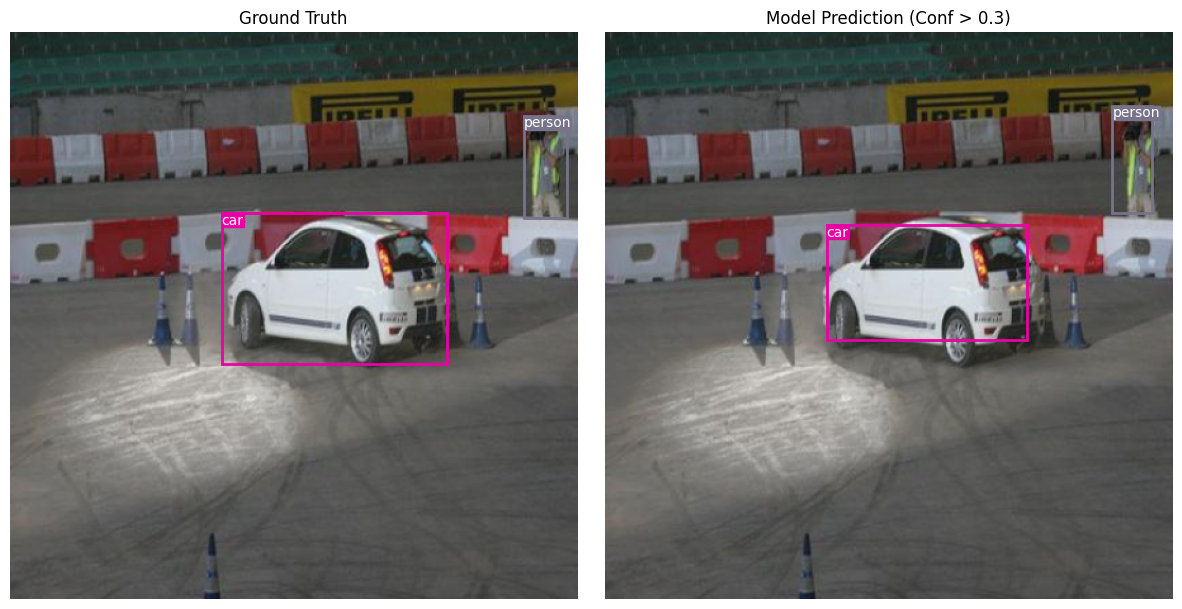

In [34]:
# --- EXECUTION BLOCK ---
# 1. Load the model architecture
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

# 2. Load the best checkpoint weights
checkpoint_path = "yolov1_best.pth.tar" 

if os.path.exists(checkpoint_path):
    print(f"=> Loading {checkpoint_path} for testing...")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
else:
    print(f"=> Warning: {checkpoint_path} not found. Using current model weights.")

# 3. Setup Data Loader for visual testing (Shuffle=True to see random images)
test_vis_loader = DataLoader(
    dataset=VOCDataset(makeCSVfile(dataset, '/test'), transform=transform, img_dir=IMG_DIR_TEST, label_dir=LABEL_DIR_TEST),
    batch_size=8, 
    num_workers=NUM_WORKERS, 
    shuffle=True
)

# 4. Run Visualization
print("\n=== VISUALIZING MODEL PREDICTIONS ===")
visualize_results(
    model, 
    test_vis_loader, 
    device=DEVICE, 
    iou_threshold=0.5,  # Lower to remove overlapping boxes
    threshold=0.3,      # Confidence threshold (lower this if no boxes appear)
    num_samples=5       # How many images to show
)

### 21. Model Metrics and Initialization
In this cell, we instantiate the `Yolov1` model and define a utility function `print_model_metrics` to calculate the model's memory footprint (in MB) and the total number of trainable parameters. This helps verify that the model architecture fits within our hardware constraints.

In [ ]:
def print_model_metrics(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"------------------------------------------------")
    print(f"Model Size: {size_all_mb:.2f} MB")
    print(f"Total Parameters: {total_params:,}")
    print(f"------------------------------------------------")


model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

print_model_metrics(model)

------------------------------------------------
Model Size: 327.35 MB
Total Parameters: 85,787,534
------------------------------------------------


### 22. Inference Speed Benchmarking (FPS)
Here we measure the model's real-world performance. We create a `test_vis_loader` and define `calculate_fps` to benchmark the inference speed. The function includes a **warm-up phase** (essential for accurate GPU timing) and calculates the average Frames Per Second (FPS) and inference time in milliseconds.

In [ ]:
test_vis_loader = DataLoader(
    dataset=VOCDataset(makeCSVfile(dataset_location, '/test'), transform=transform, img_dir=IMG_DIR_TEST, label_dir=LABEL_DIR_TEST),
    batch_size=8, 
    num_workers=NUM_WORKERS, 
    shuffle=True
)

def calculate_fps(model, loader, device="cuda", samples=100):
    model.eval()
    times = []
    count = 0
    
    print("Benchmarking FPS...")
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            # Warmup
            if count < 10:
                _ = model(x)
                count += 1
                continue
            
            start_time = time.time()
            _ = model(x)
            end_time = time.time()
            
            # Calculate time per batch, then divide by batch size for single image time
            batch_time = end_time - start_time
            times.append(batch_time / x.shape[0])
            
            count += 1
            if count > samples:
                break
                
    avg_time = np.mean(times)
    fps = 1 / avg_time
    print(f"------------------------------------------------")
    print(f"Average Inference Time: {avg_time*1000:.2f} ms")
    print(f"FPS (Frames Per Second): {fps:.2f}")
    print(f"------------------------------------------------")

calculate_fps(model, test_vis_loader, DEVICE)

Benchmarking FPS...
------------------------------------------------
Average Inference Time: 0.72 ms
FPS (Frames Per Second): 1382.19
------------------------------------------------
